<a href="https://colab.research.google.com/github/Tithi8/Neural-Networks-on-EEG-Classification/blob/main/MOABB_Dataset_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalação dos Modulos Necessários (https://braindecode.org/stable/install/install.html)

In [ ]:
#Installing the necessary modules

!pip install -U https://api.github.com/repos/braindecode/braindecode/zipball/master#egg=braindecode
!pip install https://github.com/NeuroTechX/moabb/archive/refs/heads/develop.zip


MOABB Dataset Example (https://braindecode.org/stable/auto_examples/datasets_io/plot_moabb_dataset_example.html)

In [ ]:
from braindecode.datasets import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[subject_id])

Basic Brain Decoding on EEG Data (https://braindecode.org/stable/auto_examples/model_building/plot_train_in_pure_pytorch_and_pytorch_lightning.html#sphx-glr-auto-examples-model-building-plot-train-in-pure-pytorch-and-pytorch-lightning-py)

In [ ]:
#Preprocessing, the offline transformation of the raw dataset

import numpy as np

from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor,
)


low_cut_hz = 4.0  # low cut frequency for filtering OBS. frequencias escolhidas dado ao fato por conta do paradigma usado (EEG)
high_cut_hz = 38.0  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

transforms = [
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(
        lambda data, factor: np.multiply(data, factor),  # Convert from V to uV
        factor=1e6,
    ),
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(
        exponential_moving_standardize,  # Exponential moving standardization
        factor_new=factor_new,
        init_block_size=init_block_size,
    ),
]

# Transform the data
preprocess(dataset, transforms, n_jobs=-1)



In [ ]:
#Cut Compute Windows

#Extracting Compute Windows -> Now we extract compute windows from the signals, t these will be the inputs to the deep networks during training.
#These will be the inputs to the deep networks during training. In the case of trialwise decoding, we just have to decide if we want to include some part before and/or after the trial.

from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info["sfreq"]
assert all([ds.raw.info["sfreq"] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

for x, y in dataset:
    print(x.shape, y)
    break

dataset.description

In [ ]:
#Create Pytorch model

import torch
from braindecode.models import EEGNetv4
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 42
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = windows_dataset[0][0].shape[0]
input_window_samples = windows_dataset[0][0].shape[1]

#Using EEGNet v4

model = (EEGNetv4)(
    n_channels,
    n_classes,
    n_times=input_window_samples,
    final_conv_length="auto",
)

# Display torchinfo table describing the model
print(model)
#print(EEGNetv4.__doc__)

# Send model to GPU
if cuda:
    model.cuda()
#

Training and Testing of the Model (https://braindecode.org/stable/auto_examples/model_building/plot_train_in_pure_pytorch_and_pytorch_lightning.html#id7)

In [ ]:
splitted = windows_dataset.split("session")
train_set = splitted['0train']  # Session train
test_set = splitted['1test']  # Session evaluation
#

Option 1: Pure PyTorch training loop.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LRScheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import Module
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#adjust the hyperparameters
lr = 0.001
weight_decay = 0
batch_size = 64
n_epochs = 1500
#

In [ ]:
# Define a method for training one epoch
def train_one_epoch(
    dataloader: DataLoader, model: Module, loss_fn, optimizer,
    scheduler: CosineAnnealingLR, epoch: int, device
):
    model.train()  # Set the model to training mode
    train_loss, correct = 0, 0

    for batch_idx, (X, y, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()  # update the model weights
        optimizer.zero_grad()
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()

    # Update the learning rate
    scheduler.step()

    correct /= len(dataloader.dataset)
    return train_loss / len(dataloader), correct

def test_model(
    dataloader: DataLoader, model: Module, loss_fn, device
):
    size = len(dataloader.dataset)
    n_batches = len(dataloader)
    model.eval()  # Switch to evaluation mode
    test_loss, correct = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (X, y, _) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            batch_loss = loss_fn(pred, y).item()

            test_loss += batch_loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= n_batches
    correct /= size

    return test_loss, correct, all_labels, all_preds

# Define the optimization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
# Define the loss function
loss_fn = torch.nn.NLLLoss()

# train_set and test_set are instances of torch Datasets, and can seamlessly be
# wrapped in data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)

# Initialize variables to accumulate values for each metric
total_train_accuracy = 0
total_train_loss = 0
total_valid_accuracy = 0
total_valid_loss = 0
total_lr = 0

# Training loop with metrics tracking
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Print the header
print(seed)
print("Epoch    Train_Accuracy    Train_Loss    Valid_Accuracy    Valid_Loss    LR")

# At the end of each epoch, print the epoch number and other metrics
for epoch in range(1, n_epochs + 1):
    train_loss, train_accuracy = train_one_epoch(train_loader, model, loss_fn, optimizer, scheduler, epoch, device,)
    test_loss, test_accuracy, all_labels, all_preds = test_model(test_loader, model, loss_fn, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(

           f"{epoch:<9}{train_accuracy:.4f}            {train_loss:.4f}         {test_accuracy:.4f}            {test_loss:.4f}      {scheduler.get_last_lr()[0]:.6f}",

    )


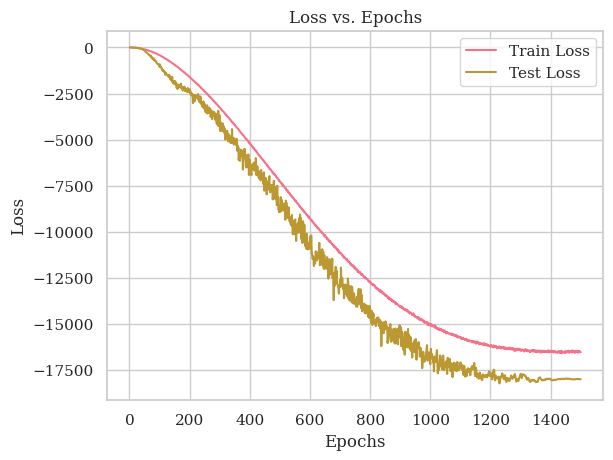

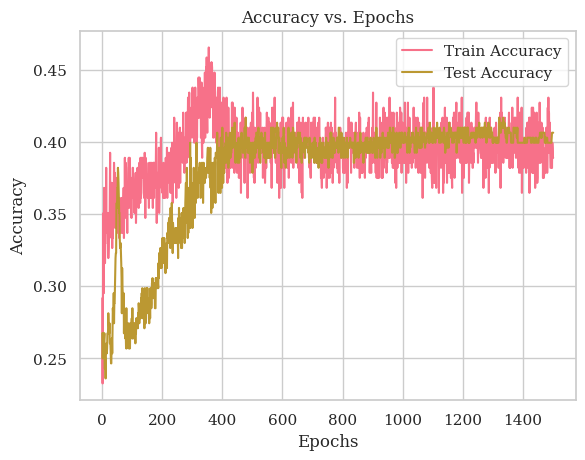

In [ ]:
# Plotting loss vs. epochs
plt.figure()
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

# Plotting accuracy vs. epochs
plt.figure()
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

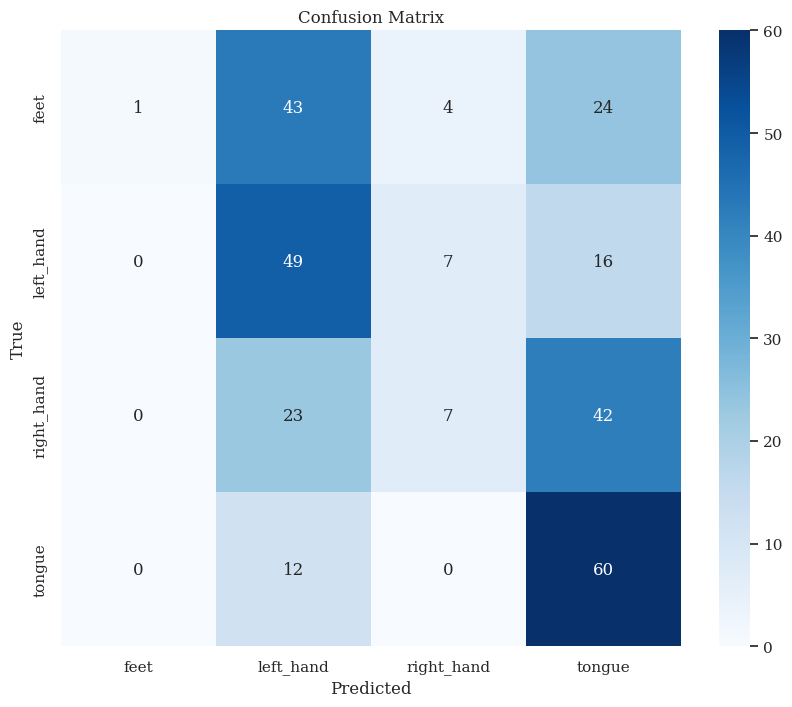

In [ ]:
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Define class names
class_names = ["feet", "left_hand", "right_hand", "tongue"]

# Assuming you have test_set, model, loss_fn, and device defined
test_loader = DataLoader(test_set, batch_size=batch_size)

# Run the test model to get predictions
test_loss, test_accuracy, all_test_labels, all_test_preds = test_model(test_loader, model, loss_fn, device)

# Plot the confusion matrix
plot_confusion_matrix(all_test_labels, all_test_preds, class_names)
